In [1]:
%pip install numpy matplotlib qiskit qiskit-aer scipy --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 31.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 65.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 76.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 3.5 MB/s eta 0:00:00


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, transpile
from qiskit.circuit import ParameterVector
from qiskit.quantum_info import Statevector
from qiskit_aer import Aer
from scipy.optimize import minimize
import warnings
warnings.filterwarnings('ignore')

In [3]:
class BarrenPlateauCircuit:
    """
    Class to demonstrate barren plateaus in variational quantum circuits.
    Implements hardware-efficient ansatz with configurable depth.
    """

    def __init__(self, num_qubits, num_layers, entanglement='full'):
        """
        Initialize the barren plateau circuit.

        Args:
            num_qubits: Number of qubits
            num_layers: Number of variational layers
            entanglement: Type of entanglement ('full', 'linear', 'circular')
        """
        self.num_qubits = num_qubits
        self.num_layers = num_layers
        self.entanglement = entanglement
        self.num_params = self._calculate_num_params()
        self.params = ParameterVector('θ', self.num_params)
        self.circuit = self._build_circuit()

    def _calculate_num_params(self):
        """Calculate total number of parameters."""
        # 3 rotation gates per qubit per layer
        return 3 * self.num_qubits * self.num_layers

    def _build_circuit(self):
        """Build the parameterized quantum circuit."""
        qc = QuantumCircuit(self.num_qubits)
        param_idx = 0

        for layer in range(self.num_layers):
            # Rotation layer
            for qubit in range(self.num_qubits):
                qc.rx(self.params[param_idx], qubit)
                param_idx += 1
                qc.ry(self.params[param_idx], qubit)
                param_idx += 1
                qc.rz(self.params[param_idx], qubit)
                param_idx += 1

            # Entanglement layer
            if layer < self.num_layers - 1:  # No entanglement after last layer
                self._add_entanglement_layer(qc)

        return qc

    def _add_entanglement_layer(self, qc):
        """Add entanglement layer based on specified pattern."""
        if self.entanglement == 'full':
            # Full entanglement: all-to-all connectivity
            for i in range(self.num_qubits):
                for j in range(i+1, self.num_qubits):
                    qc.cx(i, j)
        elif self.entanglement == 'linear':
            # Linear entanglement: nearest-neighbor
            for i in range(self.num_qubits - 1):
                qc.cx(i, i+1)
        elif self.entanglement == 'circular':
            # Circular entanglement: nearest-neighbor with periodic boundary
            for i in range(self.num_qubits - 1):
                qc.cx(i, i+1)
            if self.num_qubits > 2:
                qc.cx(self.num_qubits-1, 0)

    def get_circuit(self, params=None):
        """Return circuit with specific parameters bound."""
        if params is None:
            return self.circuit
        # Use assign_parameters instead of bind_parameters
        return self.circuit.assign_parameters(params)

In [4]:
def compute_gradient(circuit, params, observable='Z', method='parameter_shift'):
    """
    Compute gradient of expectation value using parameter shift rule.

    Args:
        circuit: BarrenPlateauCircuit instance
        params: Parameter values
        observable: Observable to measure ('Z' for Pauli-Z on first qubit)
        method: Gradient computation method

    Returns:
        gradient: Array of gradients for each parameter
    """
    gradients = np.zeros(len(params))
    shift = np.pi / 2

    for i in range(len(params)):
        # Forward shift
        params_plus = params.copy()
        params_plus[i] += shift
        exp_plus = compute_expectation(circuit, params_plus, observable)

        # Backward shift
        params_minus = params.copy()
        params_minus[i] -= shift
        exp_minus = compute_expectation(circuit, params_minus, observable)

        # Parameter shift rule
        gradients[i] = (exp_plus - exp_minus) / 2

    return gradients

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, transpile
from qiskit.circuit import ParameterVector
from qiskit.quantum_info import Statevector, Pauli
from qiskit_aer import Aer
from scipy.optimize import minimize
import warnings
warnings.filterwarnings('ignore')

def compute_expectation(circuit, params, observable='Z'):
    """
    Compute expectation value of an observable.

    Args:
        circuit: BarrenPlateauCircuit instance
        params: Parameter values
        observable: Observable to measure

    Returns:
        expectation: Expectation value
    """
    # Bind parameters to circuit
    qc = circuit.get_circuit(params)

    # Get statevector
    backend = Aer.get_backend('statevector_simulator')
    job = backend.run(qc)
    statevector = job.result().get_statevector()

    # Create Pauli object from observable string
    if observable == 'Z':
        # Pauli-Z on first qubit
        obs_pauli = Pauli('Z' + 'I' * (circuit.num_qubits - 1))
    elif observable == 'global':
        # Global observable: sum of Z on all qubits
        obs_pauli = Pauli('Z' * circuit.num_qubits)
    else:
        raise ValueError(f"Unsupported observable: {observable}")

    # Compute expectation value using Statevector.expectation_value
    expectation = statevector.expectation_value(obs_pauli)
    return np.real(expectation) # Ensure the result is real

In [6]:
def analyze_barren_plateaus(num_qubits_list, num_layers_list, num_samples, entanglement):
    """
    Analyze gradient variance for different circuit configurations.

    Args:
        num_qubits_list: List of qubit counts to test
        num_layers_list: List of layer counts to test
        num_samples: Number of random initializations
        entanglement: Type of entanglement pattern

    Returns:
        results: Dictionary with gradient statistics
    """
    results = {}

    for n_qubits in num_qubits_list:
        results[n_qubits] = {}

        for n_layers in num_layers_list:
            print(f"Analyzing: {n_qubits} qubits, {n_layers} layers")

            circuit = BarrenPlateauCircuit(n_qubits, n_layers, entanglement)
            gradient_norms = []

            for sample in range(num_samples):
                # Random initialization
                params = np.random.uniform(0, 2*np.pi, circuit.num_params)

                # Compute gradient
                gradients = compute_gradient(circuit, params, observable='Z')

                # Store gradient norm
                gradient_norms.append(np.linalg.norm(gradients))

            # Store statistics
            results[n_qubits][n_layers] = {
                'mean': np.mean(gradient_norms),
                'std': np.std(gradient_norms),
                'variance': np.var(gradient_norms),
                'raw_norms': gradient_norms
            }

    return results

In [7]:
def plot_barren_plateaus(results):
    """
    Visualize barren plateau behavior.

    Args:
        results: Dictionary from analyze_barren_plateaus
    """
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    # Plot 1: Gradient variance vs layers for different qubit counts
    ax = axes[0, 0]
    for n_qubits in results.keys():
        layers = sorted(results[n_qubits].keys())
        variances = [results[n_qubits][l]['variance'] for l in layers]
        ax.semilogy(layers, variances, 'o-', label=f'{n_qubits} qubits')
    ax.set_xlabel('Number of Layers')
    ax.set_ylabel('Gradient Variance (log scale)')
    ax.set_title('Gradient Variance vs Circuit Depth')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Plot 2: Gradient distribution for deepest circuit
    ax = axes[0, 1]
    max_qubits = max(results.keys())
    max_layers = max(results[max_qubits].keys())
    gradient_norms = results[max_qubits][max_layers]['raw_norms']
    ax.hist(gradient_norms, bins=30, alpha=0.7, edgecolor='black')
    ax.set_xlabel('Gradient Norm')
    ax.set_ylabel('Frequency')
    ax.set_title(f'Gradient Distribution ({max_qubits} qubits, {max_layers} layers)')
    ax.axvline(x=np.mean(gradient_norms), color='red', linestyle='--',
               label=f'Mean: {np.mean(gradient_norms):.4f}')
    ax.legend()

    # Plot 3: Mean gradient vs qubits for different depths
    ax = axes[1, 0]
    all_layers = set()
    for n_qubits in results.keys():
        all_layers.update(results[n_qubits].keys())

    for n_layers in sorted(all_layers):
        qubits = []
        means = []
        for n_qubits in sorted(results.keys()):
            if n_layers in results[n_qubits]:
                qubits.append(n_qubits)
                means.append(results[n_qubits][n_layers]['mean'])
        if qubits:
            ax.semilogy(qubits, means, 'o-', label=f'{n_layers} layers')

    ax.set_xlabel('Number of Qubits')
    ax.set_ylabel('Mean Gradient Norm (log scale)')
    ax.set_title('Scaling of Gradient with System Size')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Plot 4: Visualization of exponential decay
    ax = axes[1, 1]
    for n_qubits in results.keys():
        layers = sorted(results[n_qubits].keys())
        means = [results[n_qubits][l]['mean'] for l in layers]
        stds = [results[n_qubits][l]['std'] for l in layers]

        ax.errorbar(layers, means, yerr=stds, fmt='o-', capsize=5,
                   label=f'{n_qubits} qubits', alpha=0.7)

    ax.set_xlabel('Number of Layers')
    ax.set_ylabel('Mean Gradient Norm ± Std')
    ax.set_title('Gradient Decay with Error Bars')
    ax.set_yscale('log')
    ax.legend()
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

Barren Plateaus Demonstration in Qiskit
Creating a simple barren plateau circuit:
Circuit has 4 qubits and 36 parameters
Computing gradients for random initialization:
Gradient norm: 0.6567
Mean gradient magnitude: 0.0440
Analyzing barren plateau behavior:
Analyzing: 4 qubits, 2 layers
Analyzing: 4 qubits, 4 layers
Analyzing: 4 qubits, 8 layers
Analyzing: 4 qubits, 12 layers
Analyzing: 4 qubits, 16 layers
Analyzing: 6 qubits, 2 layers
Analyzing: 6 qubits, 4 layers
Analyzing: 6 qubits, 8 layers
Analyzing: 6 qubits, 12 layers
Analyzing: 6 qubits, 16 layers
Analyzing: 8 qubits, 2 layers
Analyzing: 8 qubits, 4 layers
Analyzing: 8 qubits, 8 layers
Analyzing: 8 qubits, 12 layers
Analyzing: 8 qubits, 16 layers
Plotting results:


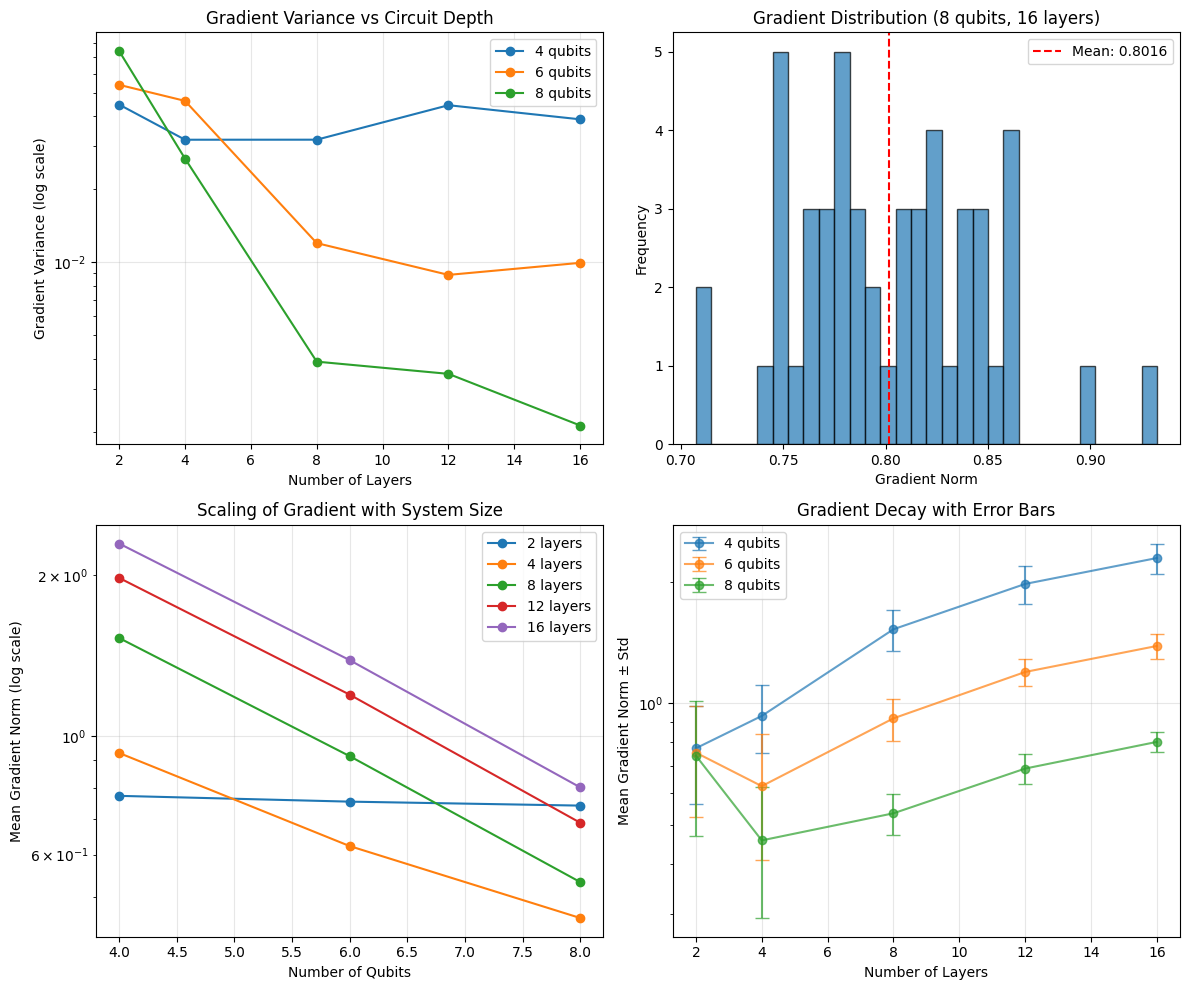

In [10]:
print("Barren Plateaus Demonstration in Qiskit")
#Basic demonstration
print("Creating a simple barren plateau circuit:")
circuit = BarrenPlateauCircuit(num_qubits=4, num_layers=3, entanglement='linear')
print(f"Circuit has {circuit.num_qubits} qubits and {circuit.num_params} parameters")

#Compute gradient for random parameters
print("Computing gradients for random initialization:")
random_params = np.random.uniform(0, 2*np.pi, circuit.num_params)
gradients = compute_gradient(circuit, random_params)
print(f"Gradient norm: {np.linalg.norm(gradients):.4f}")
print(f"Mean gradient magnitude: {np.mean(np.abs(gradients)):.4f}")

#Analyze barren plateaus
num_qubits_list=[4,6,8]
num_layers_list=[2,4,8,12,16]
num_samples=50
print("Analyzing barren plateau behavior:")
results = analyze_barren_plateaus(num_qubits_list, num_layers_list, num_samples, entanglement='linear')

#Visualize results
print("Plotting results:")
plot_barren_plateaus(results)